
# Exploring Color Networks in Urban Environments

I explore how the distribution of color in an urban environment is related to spatial distances. Specifically, we define a network based on the grid's RGB values and explore how these values influence the proximity of different grids. We will measure both Euclidean and network distances to understand how color proximity varies within the network.

## Important steps:
1. **Define the Network:**
   - Create a network where nodes represent grids, and edges represent the proximity (Euclidean and network-based) between grids.
   - Calculate the distances between grids based on their RGB values and spatial coordinates.
2. **Euclidean vs. Network Distance:**
   - Compare Euclidean distances (straight-line distance) with network distances (shortest path in the network) for the nodes.
   



In [1]:

# firstly i need divide my target space to grids, and combine it with streetview color

# the bare minimum
import matplotlib.pyplot as plt
import geopandas as gpd

# more advanced
import pyogrio as ogr
from sklearn.cluster import KMeans
from lonboard import Map, PolygonLayer
from lonboard.colormap import apply_categorical_cmap, apply_continuous_cmap
from palettable.colorbrewer.sequential import PuRd_9
from matplotlib.colors import LogNorm

import pydeck as pdk


In [4]:
df = ogr.read_dataframe("C:/Users/skyla/Downloads/pluto_by_cd/pluto_by_cd/MN/109/109.shp")
df.reset_index(drop=True, inplace=True)

<Axes: ylabel='Frequency'>

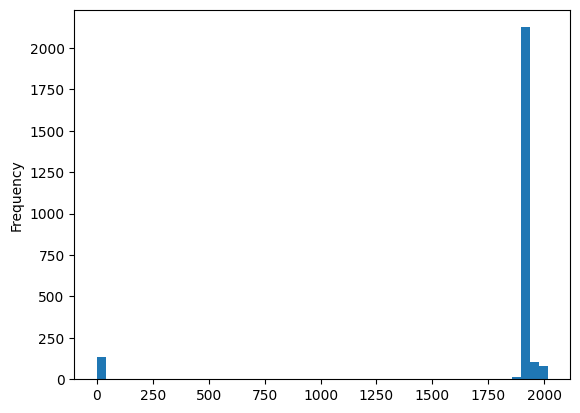

In [5]:
#find the error data and clean them
df["YearBuilt"].plot.hist(bins=50)


<Axes: ylabel='Frequency'>

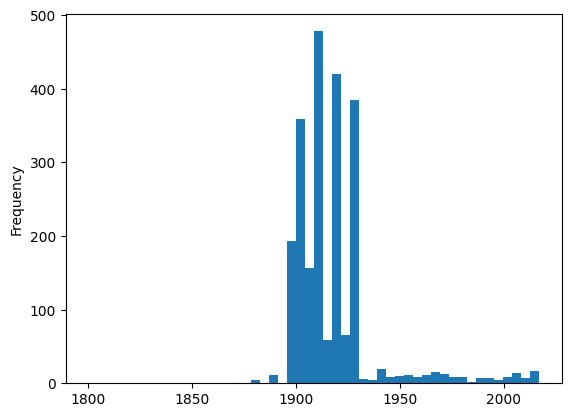

In [6]:
import datetime
# Get the current year
current_year = datetime.datetime.now().year

# Filter the data
df = df[(df["YearBuilt"] >= 250) & (df["YearBuilt"] <= current_year)]

# Check the cleaned data
df["YearBuilt"].describe()
#make sure all of the strange data is removed
df["YearBuilt"].plot.hist(bins=50)

In [7]:
import pandas as pd
# Define the bins and labels
bins = [0, 1900, 1930, 1960, 2000, 2024]
# labels = ["before 1900", "1900-1930", "1930-1960", "1960-2000", "after 2000"]
labels = [0, 1, 2, 3,4]

# Create a new column 'YearBuiltCategory'
df["YearBin"] = pd.cut(df["YearBuilt"], bins=bins, labels=labels, right=False)

#label as [0, 1, 2, 3,4]
df['YearBin'] = df['YearBin'].astype(int)
df.YearBin.describe

<bound method NDFrame.describe of 0       1
1       3
2       1
4       4
5       4
       ..
2448    3
2449    1
2450    1
2457    3
2460    3
Name: YearBin, Length: 2326, dtype: int32>

In [8]:
#divide in grid

#get the needed columns
gdf = gpd.GeoDataFrame(df[['Lot','LandUse','OwnerType','BBL','YearBuilt','geometry', 'YearBin']].drop_duplicates())
gdf = gdf.to_crs(epsg=4326)
gdf['centroid1'] = gdf['geometry'].apply(lambda geom: geom.centroid)
gdf['latitude1'] = gdf['centroid1'].apply(lambda point: point.y)
gdf['longitude1'] = gdf['centroid1'].apply(lambda point: point.x)
gdf.head()

,Lot,LandUse,OwnerType,BBL,YearBuilt,geometry,YearBin,centroid1,latitude1,longitude1
0,1,09,C,1.018500e+09,1900,"POLYGON ((-73.95715 40.81021, -73.95677 40.810...",1,POINT (-73.95838 40.80576),40.805760,-73.958376
1,2,08,C,1.018500e+09,1966,"POLYGON ((-73.95677 40.81074, -73.95715 40.810...",3,POINT (-73.95741 40.81070),40.810699,-73.957406
2,1,08,X,1.018650e+09,1900,"POLYGON ((-73.96223 40.80469, -73.96241 40.804...",1,POINT (-73.96202 40.80332),40.803318,-73.962024
4,20,03,None,1.018650e+09,2014,"POLYGON ((-73.96057 40.80367, -73.96112 40.803...",4,POINT (-73.96143 40.80419),40.804193,-73.961429
5,40,03,None,1.018650e+09,2008,"POLYGON ((-73.96107 40.80224, -73.96112 40.802...",4,POINT (-73.96169 40.80237),40.802368,-73.961689


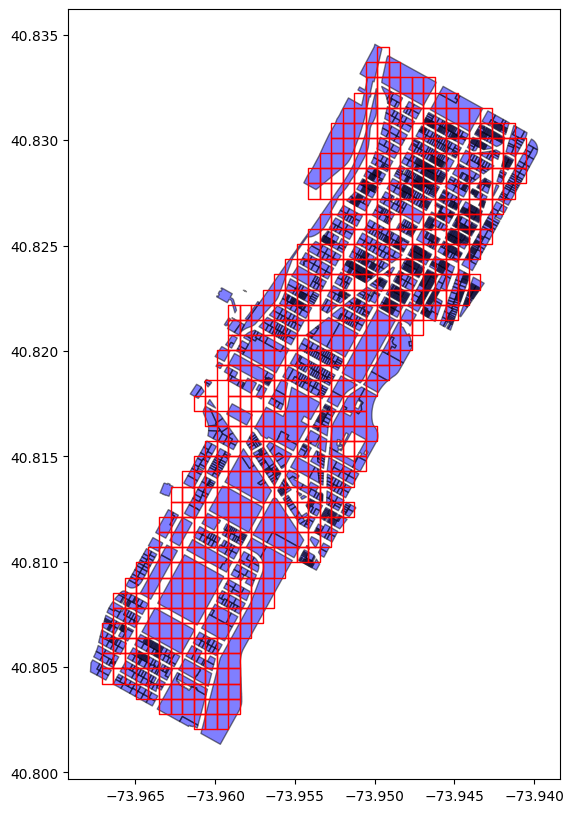

2464


In [9]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import box
import matplotlib.pyplot as plt
import numpy as np

# Get bounds
bounds = gdf.total_bounds  # (minx, miny, maxx, maxy)

# Calculate width and height
minx, miny, maxx, maxy = bounds
total_width = maxx - minx
total_height = maxy - miny

# Calculate the grid cell size to make the total number close to target number
grid_size = 1800
cell_size = np.sqrt((total_width * total_height) / grid_size)

# Create a GeoDataFrame containing all grid cells
grid_cells = []
x = minx
while x < maxx:
    y = miny
    while y < maxy:
        cell = box(x, y, x + cell_size, y + cell_size)
        grid_cells.append(cell)
        y += cell_size
    x += cell_size

# Create a GeoDataFrame and retain only the cells that intersect with gdf
grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=gdf.crs)
grid = grid[grid.intersects(gdf.unary_union)]

# Calculate the most edge grids for each row and column
# Get the minimum and maximum x, y coordinates for each row and column
min_x_per_row = grid.geometry.bounds.groupby(grid.geometry.bounds['miny'])['minx'].min()
max_x_per_row = grid.geometry.bounds.groupby(grid.geometry.bounds['miny'])['maxx'].max()
min_y_per_col = grid.geometry.bounds.groupby(grid.geometry.bounds['minx'])['miny'].min()
max_y_per_col = grid.geometry.bounds.groupby(grid.geometry.bounds['minx'])['maxy'].max()

# Find the edge grids for each row
is_edge_x = grid.geometry.bounds.apply(lambda row: row['minx'] == min_x_per_row[row['miny']] or row['maxx'] == max_x_per_row[row['miny']], axis=1)
# Find the edge grids for each column
is_edge_y = grid.geometry.bounds.apply(lambda row: row['miny'] == min_y_per_col[row['minx']] or row['maxy'] == max_y_per_col[row['minx']], axis=1)

# Remove edge grids
grid = grid[~(is_edge_x | is_edge_y)]

# Calculate centroids and add as new columns
grid['centroid'] = grid['geometry'].apply(lambda geom: geom.centroid)
grid['latitude'] = grid['centroid'].apply(lambda point: point.y)
grid['longitude'] = grid['centroid'].apply(lambda point: point.x)

# Visualization
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='blue', alpha=0.5, edgecolor='k')
grid.boundary.plot(ax=ax, linewidth=1, color='red')
plt.show()

print(grid.size)


In [10]:
from scipy.spatial import cKDTree

# Extract the geometry coordinates from gdf for nearest neighbor search
gdf_coords = gdf.geometry.apply(lambda geom: (geom.centroid.x, geom.centroid.y)).to_list()

# Create a KD tree to accelerate the nearest neighbor search
tree = cKDTree(gdf_coords)
grid_coords = grid['centroid'].apply(lambda geom: (geom.x, geom.y)).to_list()
distances, indices = tree.query(grid_coords)

# Retrieve the attribute values of the nearest neighbors
nearest_values = gdf.iloc[indices][['Lot', 'LandUse', 'BBL', 'YearBuilt', 'YearBin', 'centroid1', 'latitude1', 'longitude1']].reset_index(drop=True)

# Merge the nearest neighbor attribute values into the grid
grid = pd.concat([grid.reset_index(drop=True), nearest_values.reset_index(drop=True)], axis=1)


In [11]:
grid = grid.dropna(subset=['YearBin'])

# Reindex the DataFrame to ensure continuous numbering
grid.reset_index(drop=True, inplace=True)
grid

,geometry,centroid,latitude,longitude,Lot,LandUse,BBL,YearBuilt,YearBin,centroid1,latitude1,longitude1
0,"POLYGON ((-73.96638 40.80422, -73.96638 40.804...",POINT (-73.96673 40.80457),40.804575,-73.966735,7501,04,1.018948e+09,1926,1,POINT (-73.96688 40.80485),40.804847,-73.966876
1,"POLYGON ((-73.96638 40.80493, -73.96638 40.805...",POINT (-73.96673 40.80529),40.805294,-73.966735,43,03,1.018940e+09,1908,1,POINT (-73.96664 40.80525),40.805246,-73.966641
2,"POLYGON ((-73.96638 40.80565, -73.96638 40.806...",POINT (-73.96673 40.80601),40.806013,-73.966735,8,03,1.018950e+09,1924,1,POINT (-73.96660 40.80605),40.806048,-73.966597
3,"POLYGON ((-73.96638 40.80637, -73.96638 40.807...",POINT (-73.96673 40.80673),40.806732,-73.966735,43,02,1.018950e+09,1910,1,POINT (-73.96664 40.80689),40.806894,-73.966641
4,"POLYGON ((-73.96566 40.80422, -73.96566 40.804...",POINT (-73.96602 40.80457),40.804575,-73.966016,61,05,1.018820e+09,1920,1,POINT (-73.96596 40.80455),40.804546,-73.965965
...,...,...,...,...,...,...,...,...,...,...,...,...
611,"POLYGON ((-73.94120 40.82939, -73.94120 40.830...",POINT (-73.94156 40.82975),40.829746,-73.941564,46,08,1.020690e+09,1974,3,POINT (-73.94145 40.82975),40.829752,-73.941452
612,"POLYGON ((-73.94120 40.83011, -73.94120 40.830...",POINT (-73.94156 40.83047),40.830465,-73.941564,66,02,1.020680e+09,1901,1,POINT (-73.94183 40.83058),40.830577,-73.941828
613,"POLYGON ((-73.94048 40.82795, -73.94048 40.828...",POINT (-73.94084 40.82831),40.828308,-73.940845,46,03,1.020540e+09,1926,1,POINT (-73.94082 40.82830),40.828296,-73.940817
614,"POLYGON ((-73.94048 40.82867, -73.94048 40.829...",POINT (-73.94084 40.82903),40.829027,-73.940845,89,02,1.020540e+09,1920,1,POINT (-73.94083 40.82885),40.828849,-73.940831


In [ ]:

grid.to_csv('grid1.csv', index=False)

In [ ]:
#get street view with specific heading (from street view sample point to my target lot)
import pandas as pd
import requests
import math
import os


df = pd.read_csv('grid1.csv')

df_sample = df

# Google Maps API key
api_key = ':)'  


def get_street_view_image(latitude, longitude, heading, output_file):
    base_url = "https://maps.googleapis.com/maps/api/streetview"
    params = {
        'size': '400x400',  
        'location': f'{latitude},{longitude}',
        'heading': heading,
        'fov': 90,  
        'pitch': 0,  
        'key': api_key
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        with open(output_file, 'wb') as file:
            file.write(response.content)
        print(f"Saved image to {output_file}")
    else:
        print(f"Error fetching image for location ({latitude}, {longitude}) with heading {heading}")


def calculate_heading(lat1, lon1, lat2, lon2):
    dLon = lon2 - lon1
    y = math.sin(dLon) * math.cos(lat2)
    x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(dLon)
    heading = math.atan2(y, x)
    heading = math.degrees(heading)
    heading = (heading + 360) % 360  
    return heading


output_dir = 'C:/Users/skyla/OneDrive/Desktop/sv2'
os.makedirs(output_dir, exist_ok=True)

for index, row in df_sample.iterrows():
    latitude = row['latitude']
    longitude = row['longitude']
    centroid_latitude = row['latitude1']
    centroid_longitude = row['longitude1']

    heading = calculate_heading(latitude, longitude, centroid_latitude, centroid_longitude)

    output_file = os.path.join(output_dir, f"{index}.jpg")
    get_street_view_image(latitude, longitude, heading, output_file)

print(df_sample[['latitude', 'longitude', 'latitude1', 'longitude1']])


In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd

def get_average_color(image, image_processing_size=None):
    """
    Calculate the average color in an image.
    :param image: PIL Image
    :param image_processing_size: resize the image for faster processing
    :return: (r, g, b)
    """
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    if image_processing_size:
        image = image.resize((image.width // 10, image.height // 10))
    
    pixels = np.array(image)
    average_color = np.mean(pixels, axis=(0, 1))
    return tuple(map(int, average_color))

def create_color_block(color, size=(100, 100)):
    """
    Create a square image of a given color.
    :param color: (r, g, b)
    :param size: (width, height)
    :return: PIL Image
    """
    return Image.new("RGB", size, color)

def calculate_hue(color):
    """
    Calculate the hue of an RGB color.
    :param color: (r, g, b)
    :return: hue value
    """
    r, g, b = color
    r, g, b = r / 255.0, g / 255.0, b / 255.0
    maxc = max(r, g, b)
    minc = min(r, g, b)
    if minc == maxc:
        return 0
    if maxc == r:
        h = (g - b) / (maxc - minc)
    elif maxc == g:
        h = 2.0 + (b - r) / (maxc - minc)
    else:
        h = 4.0 + (r - g) / (maxc - minc)
    h = (h / 6.0) % 1.0
    return int(h * 255)

def process_images(input_folder, output_folder,csv_path):
    """
    Process all images in the input folder to extract the average color and save color blocks.
    :param input_folder: folder with input images
    :param output_folder: folder to save color blocks
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    data = []

    for filename in os.listdir(input_folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(input_folder, filename)
            image = Image.open(image_path)
            average_color = get_average_color(image)
            color_block = create_color_block(average_color)
            
            base_name, ext = os.path.splitext(filename)
            color_block_path = os.path.join(output_folder, f"{base_name}-color{ext}")
            color_block.save(color_block_path)
            
            data.append({
                "Image ID": base_name,
                "RGB": average_color,
                "Hue": calculate_hue(average_color)
            })

    df = pd.DataFrame(data)

  
    df = df.sort_values("Hue").reset_index(drop=True)
    df.to_csv(csv_path, index=False)


In [ ]:
input_folder = "C:/Users/skyla/OneDrive/Desktop/sv2"  
output_folder = "C:/Users/skyla/OneDrive/Desktop/sv2/svc"  
csv_path = "dominant_colors2.csv"  # calculate the main rgb of each grid

process_images(input_folder, output_folder)

In [15]:
# Load the provided CSV file
file_path = 'merged_data.csv'
data = pd.read_csv(file_path)

# Display the first few rows to understand the content
data.head()

,Image ID,RGB,Hue,SortColor,geometry,centroid,latitude,longitude,ZipCode,LandUse,OwnerType,YearBuilt,YearBin,SVI_ID,SortYear
0,299,"(106, 116, 133)",154,271,"POLYGON ((-73.95343011862006 40.8121262871848,...",POINT (-73.9537897052823 40.81248587384705),40.812486,-73.953790,10027,8.0,X,1860,0,299,0
1,567,"(126, 138, 156)",153,496,POLYGON ((-73.94480003872626 40.83082479362157...,POINT (-73.9451596253885 40.83118438028382),40.831184,-73.945160,10032,9.0,X,1882,0,567,1
2,581,"(226, 225, 221)",34,606,POLYGON ((-73.94408086540177 40.83082479362157...,POINT (-73.94444045206401 40.83118438028382),40.831184,-73.944440,10032,9.0,X,1882,0,581,2
3,572,"(107, 118, 135)",153,270,POLYGON ((-73.94408086540177 40.82435223370115...,POINT (-73.94444045206401 40.8247118203634),40.824712,-73.944440,10031,4.0,NaN,1890,0,572,3
4,594,"(141, 152, 160)",145,487,"POLYGON ((-73.9426425187528 40.82579058035013,...",POINT (-73.94300210541503 40.82615016701238),40.826150,-73.943002,10031,4.0,NaN,1890,0,594,4


In [16]:
#calculate by two types of distance
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

# Helper function to calculate RGB distance
def rgb_distance(rgb1, rgb2):
    return np.linalg.norm(np.array(rgb1) - np.array(rgb2))

# Function to calculate distances
def calculate_distances(df):
    coords = df[['longitude', 'latitude']].to_numpy()
    rgb_values = df['RGB'].apply(eval).to_numpy()
    
    # Calculate Euclidean distances
    euclidean_distances = pairwise_distances(coords, metric='euclidean')
    
    # Calculate RGB distances
    rgb_distances = pairwise_distances(list(rgb_values), metric=rgb_distance)
    
    return euclidean_distances, rgb_distances



In [17]:
# Function to build the network
def build_network(df, threshold=0.1):
    G = nx.Graph()
    coords = df[['longitude', 'latitude']].to_numpy()
    rgb_values = df['RGB'].apply(eval).to_numpy()
    
    for i, (coord, rgb) in enumerate(zip(coords, rgb_values)):
        G.add_node(i, pos=coord, rgb=rgb)
    
    euclidean_distances, rgb_distances = calculate_distances(df)
    
    for i in range(len(df)):
        for j in range(i + 1, len(df)):
            if euclidean_distances[i, j] <= threshold:
                G.add_edge(i, j, weight=euclidean_distances[i, j])
    
    return G, euclidean_distances, rgb_distances

# Build the network
G, euclidean_distances, rgb_distances = build_network(data)


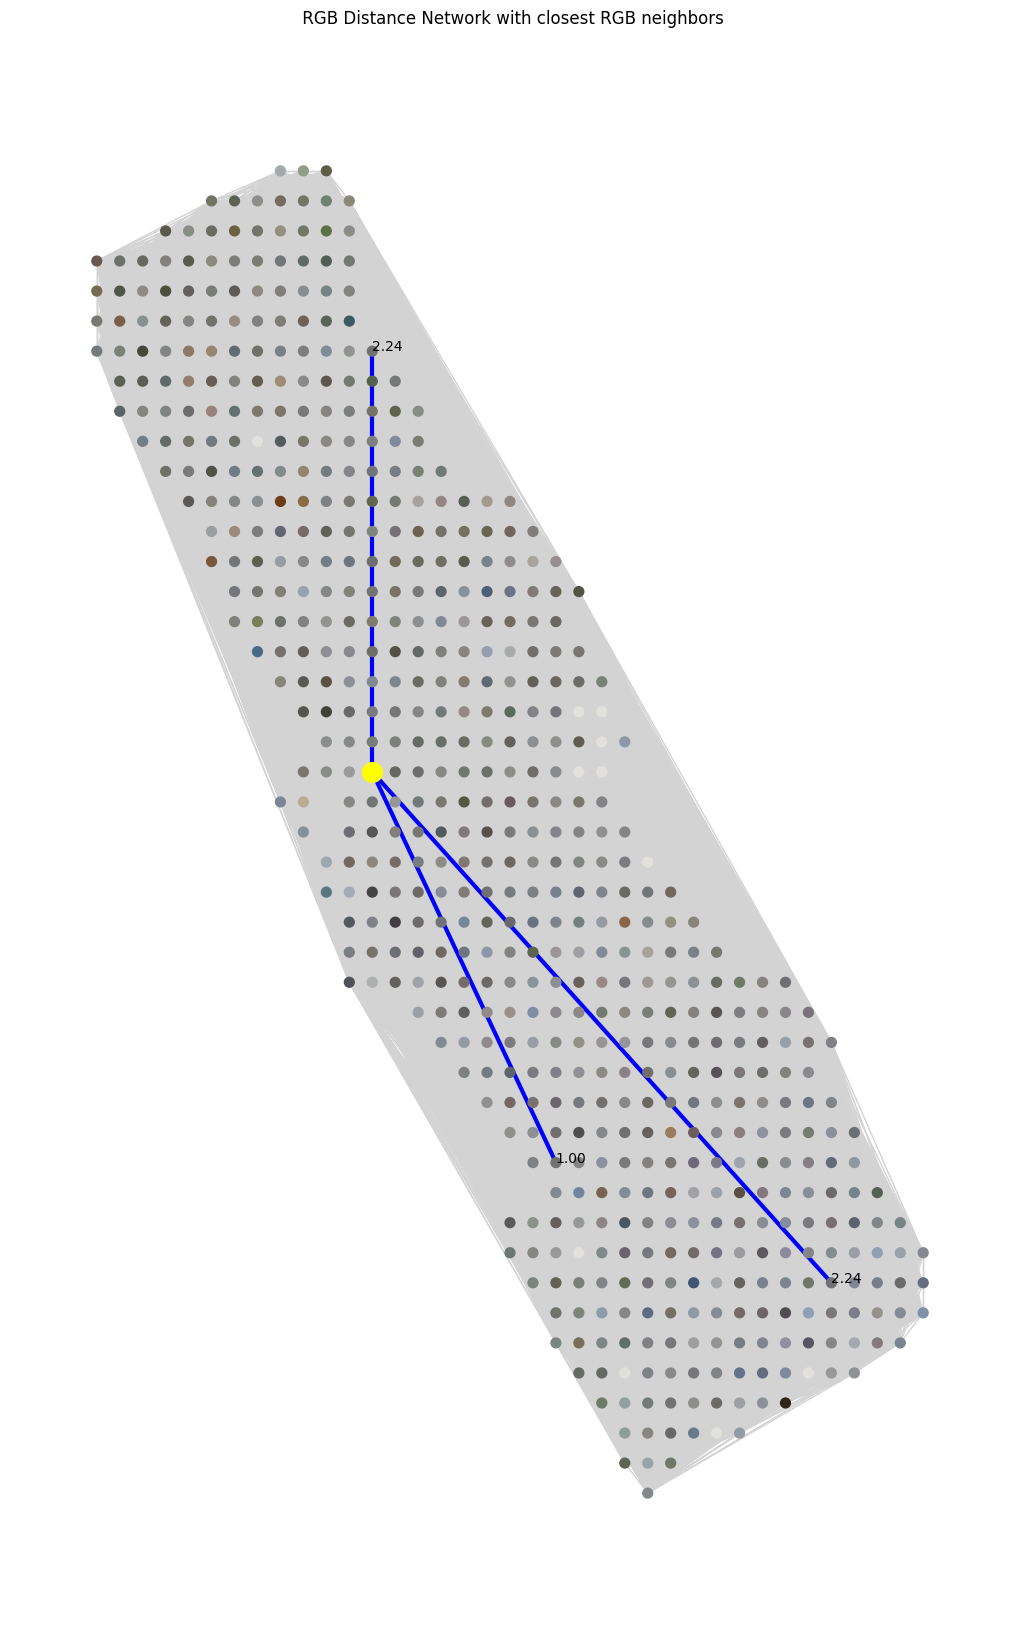

Selected Node: 607
Neighbor: 134, RGB Distance: 1.00
Neighbor: 401, RGB Distance: 2.24
Neighbor: 562, RGB Distance: 2.24


In [25]:
import matplotlib.pyplot as plt
import networkx as nx
import random

# Function to visualize the network with correct grid alignment
def visualize_with_correct_grid(G, random_node, neighbors_by_rgb):
    pos = nx.get_node_attributes(G, 'pos')
    rgb = nx.get_node_attributes(G, 'rgb')
    
    # Create a figure with the appropriate size
    plt.figure(figsize=(10, 16))
    
    # Draw the nodes without labels for clarity
    nx.draw(G, pos, node_color=[normalize_rgb(rgb[n]) for n in G.nodes], with_labels=False, node_size=50, edge_color='lightgray')
    
    # Highlight the selected node
    nx.draw_networkx_nodes(G, pos, nodelist=[random_node], node_color='yellow', node_size=200)
    
    # Highlight the edges to the closest RGB neighbors
    for neighbor in neighbors_by_rgb:
        nx.draw_networkx_edges(G, pos, edgelist=[(random_node, neighbor)], edge_color='blue', width=3)
        # Annotate with RGB distance
        plt.text(pos[neighbor][0], pos[neighbor][1], f"{rgb_distance(G.nodes[random_node]['rgb'], G.nodes[neighbor]['rgb']):.2f}", fontsize=10, color='black')

    plt.title(' RGB Distance Network with closest RGB neighbors')
    plt.gca().invert_yaxis()  # Invert Y-axis if necessary to match the correct map orientation
    plt.axis('off')  # Turn off axis lines for a cleaner look
    plt.show()

# Select a random node and find its closest RGB neighbors
random_node = random.choice(list(G.nodes))
neighbors_by_rgb = sorted(G.nodes, key=lambda x: rgb_distance(G.nodes[random_node]['rgb'], G.nodes[x]['rgb']))[1:4]

# Visualize the network with your grid and corrections
visualize_with_correct_grid(G, random_node, neighbors_by_rgb)

# Print the selected node and its nearest neighbors based on RGB distance
print(f"Selected Node: {random_node}")
for neighbor in neighbors_by_rgb:
    print(f"Neighbor: {neighbor}, RGB Distance: {rgb_distance(G.nodes[random_node]['rgb'], G.nodes[neighbor]['rgb']):.2f}")


In [52]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

# Load the grid data
grid_data = pd.read_csv('merged_data.csv')

# Convert the geometry column to actual geometries using GeoPandas
grid_data['geometry'] = grid_data['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(grid_data, geometry='geometry')

# Parse the RGB string into a tuple of integers
def parse_rgb(rgb_string):
    return tuple(map(int, rgb_string.strip('()').split(',')))

# Determine the closest color category based on the RGB values
def classify_color(rgb_tuple):
    r, g, b = rgb_tuple
    if r >= g and r >= b:
        if g > 150:
            return 'yellow'  # When red and green are dominant
        else:
            return 'red'     # When red is dominant
    elif g >= r and g >= b:
        if r > 150:
            return 'yellow'  # When red and green are dominant
        else:
            return 'green'   # When green is dominant
    elif b >= r and b >= g:
        return 'blue'        # When blue is dominant

gdf['color_category'] = gdf['RGB'].apply(lambda x: classify_color(parse_rgb(x)))

# Count the number of grids for each color category
color_counts = gdf['color_category'].value_counts()

# Display the counts
print(color_counts)


color_category
blue      223
red       215
green     156
yellow     22
Name: count, dtype: int64


KeyboardInterrupt: 

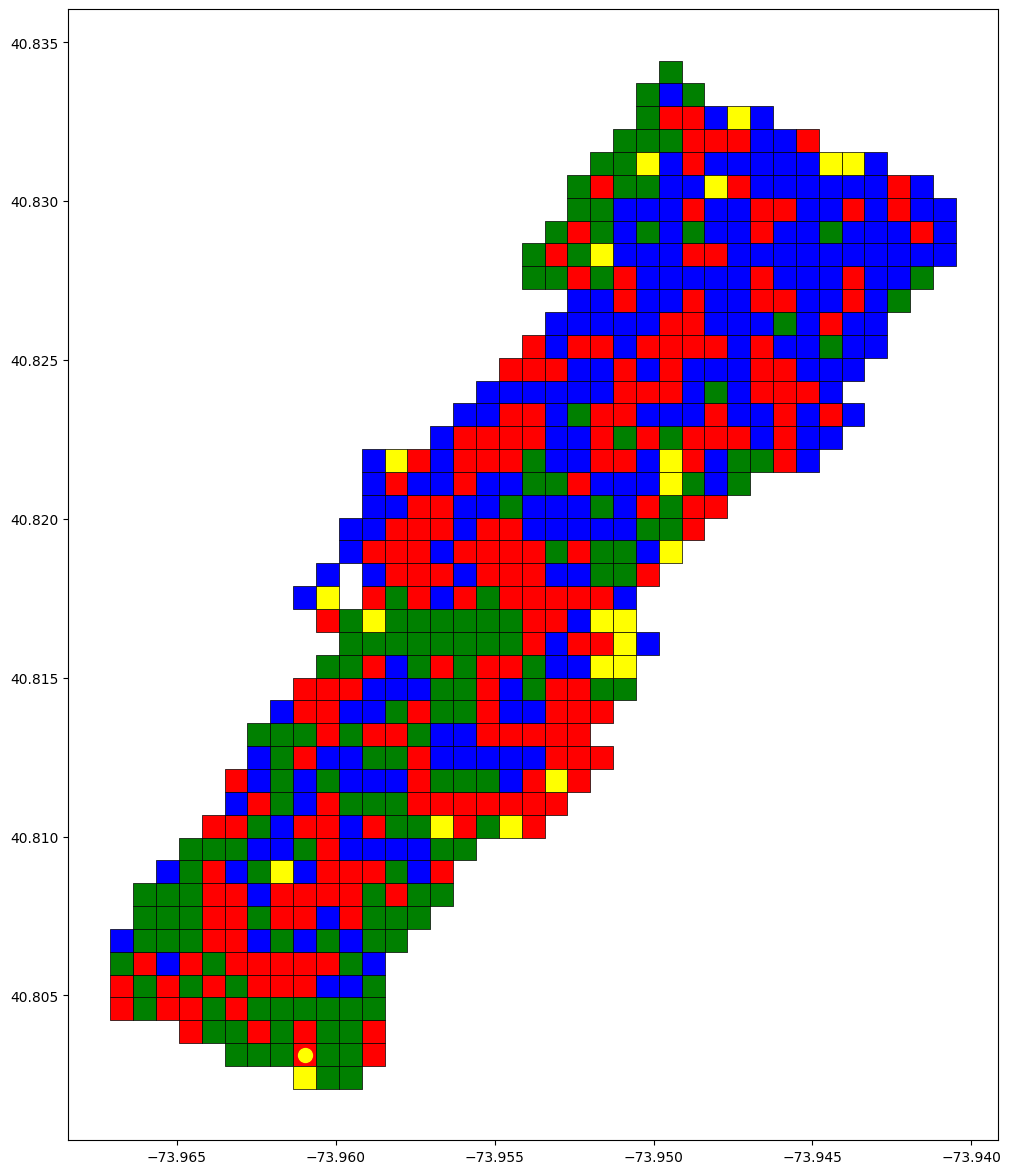

In [59]:
#too slow...
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from shapely import wkt
import numpy as np
import random
from sklearn.metrics import pairwise_distances
from scipy.spatial import Voronoi

# Load the grid data
grid_data = pd.read_csv('merged_data.csv')

# Convert the geometry column to actual geometries using GeoPandas
grid_data['geometry'] = grid_data['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(grid_data, geometry='geometry')

# Parse the RGB string into a tuple of integers
def parse_rgb(rgb_string):
    return tuple(map(int, rgb_string.strip('()').split(',')))

# Determine the closest color category based on the RGB values
def classify_color(rgb_tuple):
    r, g, b = rgb_tuple
    if r >= g and r >= b:
        if g > 150:
            return 'yellow'  # When red and green are dominant
        else:
            return 'red'     # When red is dominant
    elif g >= r and g >= b:
        if r > 150:
            return 'yellow'  # When red and green are dominant
        else:
            return 'green'   # When green is dominant
    elif b >= r and b >= g:
        return 'blue'        # When blue is dominant

gdf['color_category'] = gdf['RGB'].apply(lambda x: classify_color(parse_rgb(x)))

# Function to calculate the Euclidean distance between two points
def euclidean_distance(point1, point2):
    return np.sqrt((point1.x - point2.x)**2 + (point1.y - point2.y)**2)

# Find the nearest grid cell based on geometric distance
def find_nearest_grid(start_geom, target_geoms):
    min_dist = float('inf')
    nearest_idx = None
    for idx, geom in target_geoms.items():
        dist = euclidean_distance(start_geom.centroid, geom.centroid)
        if dist < min_dist:
            min_dist = dist
            nearest_idx = idx
    return nearest_idx

# Plot the grid with color categories and the paths to blue and green
def plot_grid_with_geometric_paths(gdf, start_idx, blue_idx, green_idx):
    # Create a figure with increased size
    plt.figure(figsize=(12, 18))
    
    # Plot each grid cell with the color based on the color category
    for color in ['red', 'green', 'blue', 'yellow']:
        gdf[gdf['color_category'] == color].plot(ax=plt.gca(), color=color, edgecolor='k', linewidth=0.5)
    
    # Highlight the start point
    plt.scatter(gdf.geometry.iloc[start_idx].centroid.x, gdf.geometry.iloc[start_idx].centroid.y, color='yellow', s=100, zorder=5)
    
    # Plot the path to the nearest blue grid by walking through grid centers
    path_points = [gdf.geometry.iloc[start_idx].centroid]
    current_idx = start_idx
    while current_idx != blue_idx:
        next_idx = find_nearest_grid(gdf.geometry.iloc[current_idx], gdf[gdf.index != current_idx].geometry)
        path_points.append(gdf.geometry.iloc[next_idx].centroid)
        current_idx = next_idx
    plt.plot(
        [point.x for point in path_points],
        [point.y for point in path_points],
        color='blue', linewidth=3, label='Path to nearest blue'
    )
    
    # Plot the path to the nearest green grid by walking through grid centers
    path_points = [gdf.geometry.iloc[start_idx].centroid]
    current_idx = start_idx
    while current_idx != green_idx:
        next_idx = find_nearest_grid(gdf.geometry.iloc[current_idx], gdf[gdf.index != current_idx].geometry)
        path_points.append(gdf.geometry.iloc[next_idx].centroid)
        current_idx = next_idx
    plt.plot(
        [point.x for point in path_points],
        [point.y for point in path_points],
        color='green', linewidth=3, label='Path to nearest green'
    )
    
    plt.legend()
    plt.title('Grid Visualization with Grid Paths to Nearest Blue and Green')
    plt.show()

# Select a random grid cell that is either red or yellow
valid_start_indices = gdf[(gdf['color_category'] == 'red') | (gdf['color_category'] == 'yellow')].index.to_list()
start_idx = random.choice(valid_start_indices)
start_geom = gdf.geometry.iloc[start_idx]

# Find the nearest blue and green grid cells
nearest_blue_idx = find_nearest_grid(start_geom, gdf[gdf['color_category'] == 'blue'].geometry)
nearest_green_idx = find_nearest_grid(start_geom, gdf[gdf['color_category'] == 'green'].geometry)

# Plot the paths on the grid with geometric distances following the grid
plot_grid_with_geometric_paths(gdf, start_idx, nearest_blue_idx, nearest_green_idx)


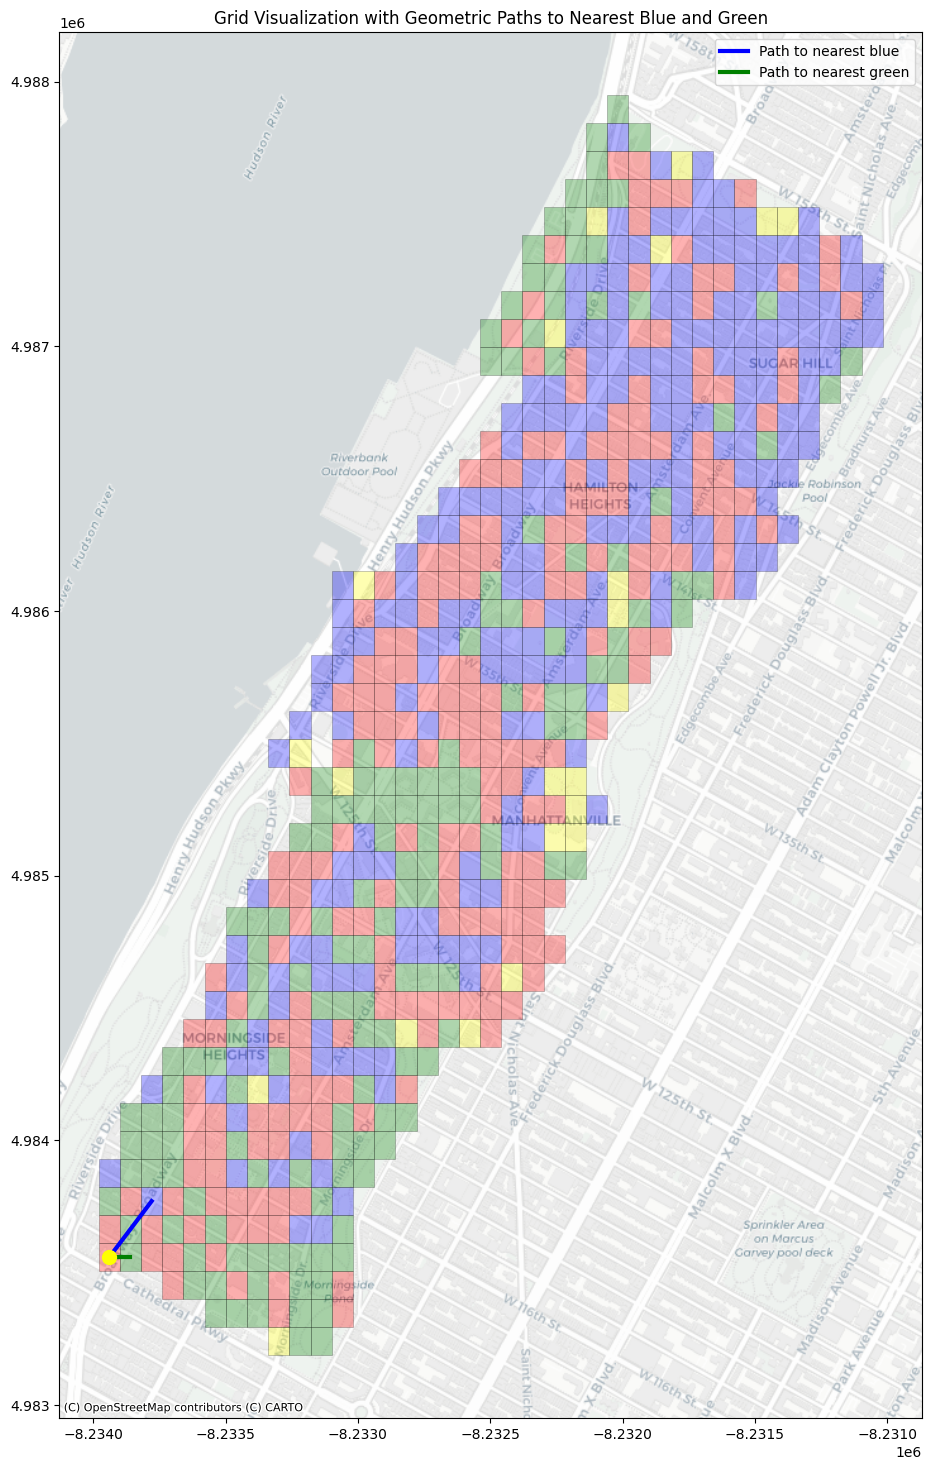

In [68]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely import wkt
import numpy as np
import random
from sklearn.metrics import pairwise_distances

# Load the grid data
grid_data = pd.read_csv('merged_data.csv')

# Convert the geometry column to actual geometries using GeoPandas
grid_data['geometry'] = grid_data['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(grid_data, geometry='geometry', crs="EPSG:4326")

# Parse the RGB string into a tuple of integers
def parse_rgb(rgb_string):
    return tuple(map(int, rgb_string.strip('()').split(',')))

# Determine the closest color category based on the RGB values
def classify_color(rgb_tuple):
    r, g, b = rgb_tuple
    if r >= g and r >= b:
        if g > 150:
            return 'yellow'  # When red and green are dominant
        else:
            return 'red'     # When red is dominant
    elif g >= r and g >= b:
        if r > 150:
            return 'yellow'  # When red and green are dominant
        else:
            return 'green'   # When green is dominant
    elif b >= r and b >= g:
        return 'blue'        # When blue is dominant

gdf['color_category'] = gdf['RGB'].apply(lambda x: classify_color(parse_rgb(x)))

# Function to calculate the Euclidean distance between two points
def euclidean_distance(point1, point2):
    return np.sqrt((point1.x - point2.x)**2 + (point1.y - point2.y)**2)

# Find the nearest grid cell based on geometric distance
def find_nearest_grid(start_geom, target_geoms):
    min_dist = float('inf')
    nearest_idx = None
    for idx, geom in target_geoms.items():
        dist = euclidean_distance(start_geom.centroid, geom.centroid)
        if dist < min_dist:
            min_dist = dist
            nearest_idx = idx
    return nearest_idx

# Plot the grid with color categories, the paths to blue and green, and a basemap
def plot_grid_with_geometric_paths(gdf, start_idx, blue_idx, green_idx):
    # Reproject to Web Mercator for contextily basemap
    gdf = gdf.to_crs(epsg=3857)
    
    # Create a figure with increased size
    fig, ax = plt.subplots(figsize=(12, 18))
    
    # Plot each grid cell with the color based on the color category and 30% transparency
    for color in ['red', 'green', 'blue', 'yellow']:
        gdf[gdf['color_category'] == color].plot(ax=ax, color=color, edgecolor='k', linewidth=0.5, alpha=0.3)
    
    # Highlight the start point
    plt.scatter(gdf.geometry.iloc[start_idx].centroid.x, gdf.geometry.iloc[start_idx].centroid.y, color='yellow', s=100, zorder=5)
    
    # Plot the path to the nearest blue grid without transparency
    plt.plot(
        [gdf.geometry.iloc[start_idx].centroid.x, gdf.geometry.iloc[blue_idx].centroid.x],
        [gdf.geometry.iloc[start_idx].centroid.y, gdf.geometry.iloc[blue_idx].centroid.y],
        color='blue', linewidth=3, label='Path to nearest blue', alpha=1.0
    )
    
    # Plot the path to the nearest green grid without transparency
    plt.plot(
        [gdf.geometry.iloc[start_idx].centroid.x, gdf.geometry.iloc[green_idx].centroid.x],
        [gdf.geometry.iloc[start_idx].centroid.y, gdf.geometry.iloc[green_idx].centroid.y],
        color='green', linewidth=3, label='Path to nearest green', alpha=1.0
    )
    
    # Add a basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    plt.legend()
    plt.title('Grid Visualization with Geometric Paths to Nearest Blue and Green')
    plt.show()

# Select a random grid cell that is either red or yellow
valid_start_indices = gdf[(gdf['color_category'] == 'red') | (gdf['color_category'] == 'yellow')].index.to_list()
start_idx = random.choice(valid_start_indices)
start_geom = gdf.geometry.iloc[start_idx]

# Find the nearest blue and green grid cells
nearest_blue_idx = find_nearest_grid(start_geom, gdf[gdf['color_category'] == 'blue'].geometry)
nearest_green_idx = find_nearest_grid(start_geom, gdf[gdf['color_category'] == 'green'].geometry)

# Plot the paths on the grid with geometric distances and a basemap
plot_grid_with_geometric_paths(gdf, start_idx, nearest_blue_idx, nearest_green_idx)


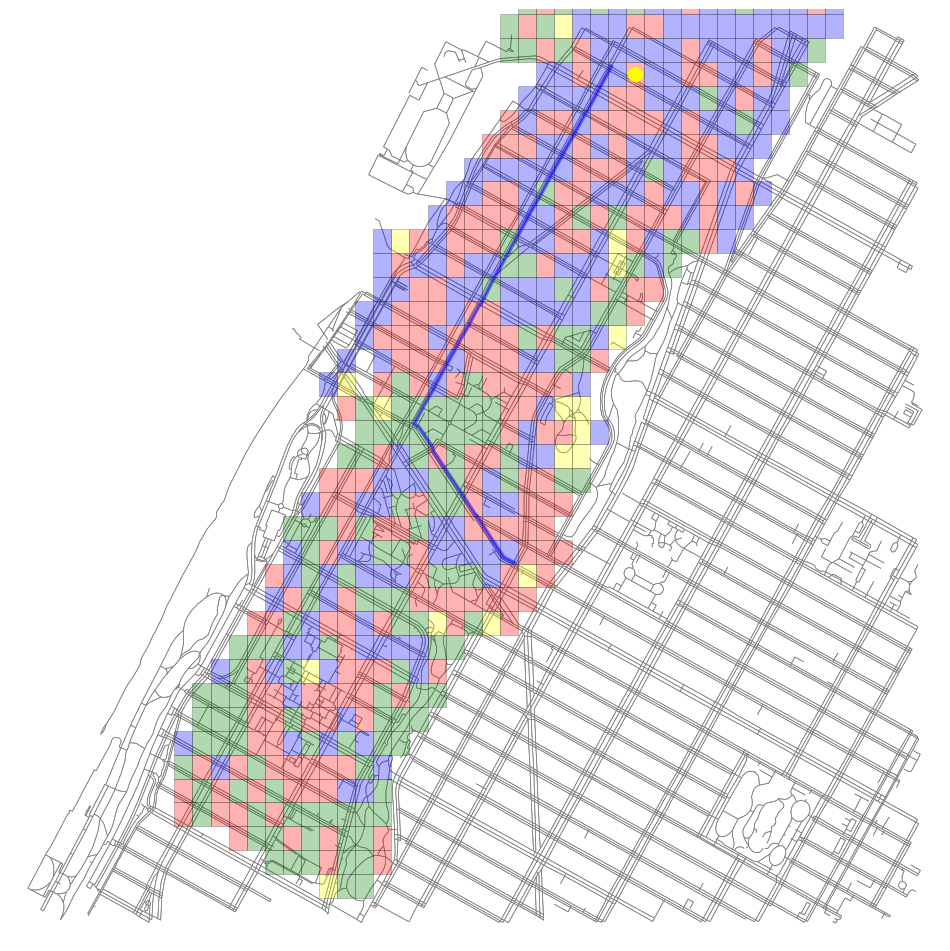

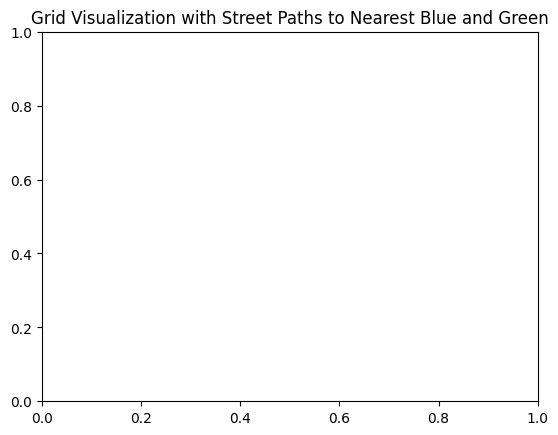

In [72]:
#still have some bugs..
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
from shapely import wkt
import numpy as np
import random

# Load the grid data
grid_data = pd.read_csv('merged_data.csv')

# Convert the geometry column to actual geometries using GeoPandas
grid_data['geometry'] = grid_data['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(grid_data, geometry='geometry', crs="EPSG:4326")

# Parse the RGB string into a tuple of integers
def parse_rgb(rgb_string):
    return tuple(map(int, rgb_string.strip('()').split(',')))

# Determine the closest color category based on the RGB values
def classify_color(rgb_tuple):
    r, g, b = rgb_tuple
    if r >= g and r >= b:
        if g > 150:
            return 'yellow'  # When red and green are dominant
        else:
            return 'red'     # When red is dominant
    elif g >= r and g >= b:
        if r > 150:
            return 'yellow'  # When red and green are dominant
        else:
            return 'green'   # When green is dominant
    elif b >= r and b >= g:
        return 'blue'        # When blue is dominant

gdf['color_category'] = gdf['RGB'].apply(lambda x: classify_color(parse_rgb(x)))

# Get the street network from OSM, covering a larger area
location_point = (40.8148, -73.9553)  # Approximate center of the area: Hamilton Heights, Manhattanville, Morningside Heights, West Harlem
G = ox.graph_from_point(location_point, dist=1500, network_type='walk')

# Convert the GeoDataFrame to the same CRS as the street network
gdf = gdf.to_crs(crs=G.graph['crs'])

# Function to snap a point to the nearest street network node
def get_nearest_node(geom):
    return ox.distance.nearest_nodes(G, X=geom.centroid.x, Y=geom.centroid.y)

# Plot the grid with color categories, the paths to blue and green, and a street network
def plot_grid_with_street_paths(gdf, start_idx, blue_idx, green_idx):
    fig, ax = plt.subplots(figsize=(12, 18))
    
    # Plot the street network
    ox.plot_graph(G, ax=ax, show=False, close=False, edge_color='gray', node_color='none', edge_linewidth=0.5, bgcolor='white')

    # Plot each grid cell with the color based on the color category and 30% transparency
    for color in ['red', 'green', 'blue', 'yellow']:
        gdf[gdf['color_category'] == color].plot(ax=ax, color=color, edgecolor='k', linewidth=0.5, alpha=0.3)
    
    # Highlight the start point
    start_point = gdf.geometry.iloc[start_idx]
    plt.scatter(start_point.centroid.x, start_point.centroid.y, color='yellow', s=100, zorder=5)
    
    # Plot the path to the nearest blue grid along the street network
    blue_node = get_nearest_node(gdf.geometry.iloc[blue_idx])
    start_node = get_nearest_node(start_point)
    blue_path = nx.shortest_path(G, source=start_node, target=blue_node, weight='length')
    ox.plot_graph_route(G, blue_path, ax=ax, route_color='blue', route_linewidth=3, orig_dest_size=0)
    
    # Plot the path to the nearest green grid along the street network
    green_node = get_nearest_node(gdf.geometry.iloc[green_idx])
    green_path = nx.shortest_path(G, source=start_node, target=green_node, weight='length')
    ox.plot_graph_route(G, green_path, ax=ax, route_color='green', route_linewidth=3, orig_dest_size=0)
    
    # Add a legend for the paths
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='blue', lw=3, label='Path to nearest blue'),
        Line2D([0], [0], color='green', lw=3, label='Path to nearest green')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.title('Grid Visualization with Street Paths to Nearest Blue and Green')
    plt.show()

# Select a random grid cell that is either red or yellow
valid_start_indices = gdf[(gdf['color_category'] == 'red') | (gdf['color_category'] == 'yellow')].index.to_list()
start_idx = random.choice(valid_start_indices)
start_geom = gdf.geometry.iloc[start_idx]

# Find the nearest blue and green grid cells
nearest_blue_idx = gdf[gdf['color_category'] == 'blue'].index.to_list()
nearest_green_idx = gdf[gdf['color_category'] == 'green'].index.to_list()

# Find the nearest nodes in the street network
blue_node = get_nearest_node(gdf.geometry.iloc[nearest_blue_idx[0]])
green_node = get_nearest_node(gdf.geometry.iloc[nearest_green_idx[0]])
start_node = get_nearest_node(start_geom)

# Plot the paths on the grid along the street network
plot_grid_with_street_paths(gdf, start_idx, nearest_blue_idx[0], nearest_green_idx[0])



## Reflection

In this analysis, we constructed a network based on RGB values and Euclidean distances between grid points. By comparing the Euclidean distances with the RGB-based network distances, we can observe how spatial proximity and color similarity are related.

### Key Observations:
- The Euclidean distance provides a straightforward measure of physical proximity between grid points.
- The network distances, influenced by color similarity, add another layer of understanding, especially in how color can influence perceived proximity in an urban environment.
- Experiential differences between these distance measures can lead to different interpretations of proximity, especially in urban planning and design contexts.